# Collective motion and agent-based simulations

Imports: Make sure these are installed in your conda env, and that the conda env is active in your notebook
+ numpy
+ matplotlib
+ scipy
+ jupyter

In [1]:
## This line imports the numpy and matplotlib libraries, which we will use in this notebook.
import numpy as np
import matplotlib.pyplot as plt

## These lines represent iPython magic commands that are unique to the notebook environment.
## In a standalone .py script, you would not include these lines. Here, we are using them to
## make the notebook interactive and to enable the autoreload extension, which will automatically
## reload our imported modules when we edit them.
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Flocking and Swarming

Groups of organisms often exhibit complex collective emergent behaviors. This phenomenon represents a tradeoff between local rules describing each individual's range of movement, and the global behavior of the group.


![A murmuration of starlings](https://www.wgilpin.com/cphy/resources/starling_murmuration.jpg)
*Walter Baxter / A murmuration of starlings at Gretna / CC BY-SA 2.0*

# The Vicsek model of self-propelled particles

The Vicsek model describes a swarm of particles, each of which moves at a fixed speed $v_0$ and adjusts its direction to align with the average direction of its neighbors. The model's governing equations are

$$
\begin{align}
\dot{x}_i &= v_0 \cos(\theta_i) \\
\dot{y}_i &= v_0 \sin(\theta_i) \\
\dot{\theta}_i &= \frac{1}{\tau} \left( \sum_{j=1}^N \sin(\theta_j) - \sin(\theta_i) \right)
\end{align}
$$

where $v_0$ is the fixed speed of the particles, $\tau$ is the relaxation time, and $x_i, y_i, \theta_i$ are the position and orientation angle of the $i$-th particle. 

We can convert these equations into a numerical simulation by discretizing time. We will see in later parts of the course that there are many ways to do this, but we will stick with one of the simplest approach: the forward Euler method. The Euler method is a first-order method that approximates the derivative of a function by the slope of a line. It consists of an approximation of the form $\dot{x}(t) \approx \frac{x(t + \Delta t) - x(t)}{\Delta t}$, where $\Delta t$ is a time step. Generally, the smaller the time step, the more accurate the approximation.

In the context of the Vicsek model, we can write the discrete-time update equations as
$$
\begin{align}
x_i(t + \Delta t) &= x_i(t) + v_0 \cos(\theta_i(t)) \Delta t \\
y_i(t + \Delta t) &= y_i(t) + v_0 \sin(\theta_i(t)) \Delta t \\
\theta_i(t + \Delta t) &= \theta_i(t) + \left( \sum_{j=1}^N \sin(\theta_j(t)) - \sin(\theta_i(t)) \right) \Delta t
\end{align}
$$

where $\Delta t$ is the time step.






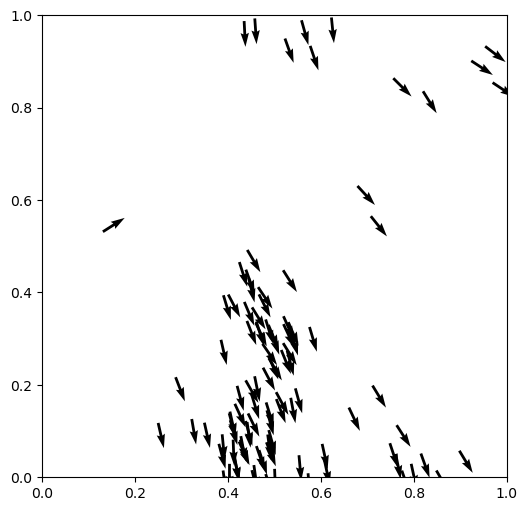

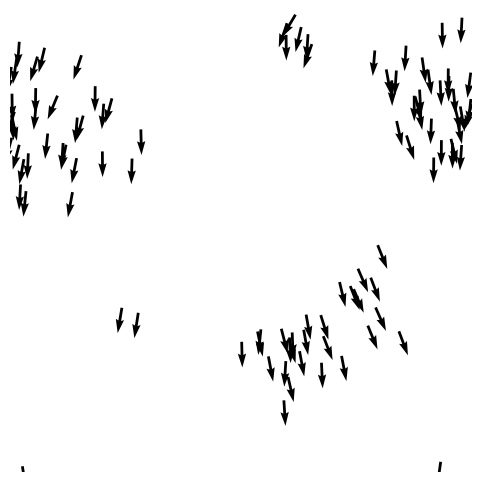

In [44]:
import numpy as np
import matplotlib.pyplot as plt


class DiscreteSimulation:

    def __init__(self, N, random_state=None, verbose=False, store_history=True):
        self.N = N
        self.verbose = verbose
        self.store_history = store_history

        if random_state is not None:
            np.random.seed(random_state)
            self.random_state = random_state

    def update(self):
        raise NotImplementedError
    
    def run(self, n_steps):
        if self.store_history:
            self.history = list()
            self.history.append(self.state.copy())
        
        for i in range(n_steps):
            self.update()
            if self.store_history:
                self.history.append(self.state.copy())
            if self.verbose:
                print(self.state)


class VicsekModel(DiscreteSimulation):
    
        def __init__(self, N, L, eta, v0, R, dt, random_state=None, verbose=False, store_history=True):
            super().__init__(N, random_state=random_state, verbose=verbose, store_history=store_history)
            self.L = L
            self.eta = eta
            self.v0 = v0
            self.R = R
            self.dt = dt
    
            self.positions = np.random.rand(N, 2) * L
            self.orientations = np.random.rand(N) * 2 * np.pi

            self.state = np.concatenate([self.positions, self.orientations[:, None]], axis=1)
    
        def update(self):
            new_orientations = np.zeros(self.N)
            for i in range(self.N):
                distances = np.linalg.norm(self.positions - self.positions[i], axis=1)
                neighbors = distances < self.R

                ## Compute which other particles are within a field of view relative
                ## to the current particle's bearing (orientation)
                ## Given the location and oridentation of particle i, find which
                ## particles are locations within the field of view of particle i.
                ## This is done by computing the angle between the orientation of particle i
                ## and the vector pointing from particle i to each other particle.
                # self.eta = 2 * np.pi + 0.01
                # angles = np.arctan2(self.positions[:, 1] - self.positions[i, 1],
                #                     self.positions[:, 0] - self.positions[i, 0])
                # angles_diff = np.abs(self.orientations - angles)
                # neighbors = np.logical_and(distances < self.R, angles_diff < self.eta)

    
                sin_sum = np.sum(np.sin(self.orientations[neighbors]))
                cos_sum = np.sum(np.cos(self.orientations[neighbors]))
                avg_direction = np.arctan2(sin_sum, cos_sum)
    
                new_orientations[i] = avg_direction + self.eta * (np.random.rand() - 0.5)

            ## Update the orientations and positions simultaneously
            self.orientations = new_orientations
            self.positions[:, 0] += self.v0 * np.cos(self.orientations) * self.dt
            self.positions[:, 1] += self.v0 * np.sin(self.orientations) * self.dt

            ## Periodic boundary conditions on the box
            self.positions = self.positions % self.L
    
        def plot(self):
            plt.figure(figsize=(6, 6))
            plt.quiver(self.positions[:, 0], self.positions[:, 1],
                    np.cos(self.orientations), np.sin(self.orientations))
            plt.xlim(0, self.L)
            plt.ylim(0, self.L)

# Example usage:
num_particles = 100
L = 1.0
eta = 0.1*4
v0 = 1.0
R = 1.0/10
dt = 0.1/4
steps = 100

model = VicsekModel(num_particles, L, eta, v0, R, dt, random_state=0)
model.run(steps)
model.plot()

## Make video
import matplotlib.animation as animation

# subplots of a square size
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(0, L)
ax.set_ylim(0, L)
ax.set_aspect('equal')
quiver = ax.quiver(model.positions[:, 0], model.positions[:, 1],
                   np.cos(model.orientations), np.sin(model.orientations))
plt.gca().axis("off")

def update(i):
    model.update()
    quiver.set_offsets(model.positions)
    quiver.set_UVC(np.cos(model.orientations), np.sin(model.orientations))
    return quiver, 

ani = animation.FuncAnimation(fig, update, frames=range(500), interval=2)
ani.save('couzin_vicsek.mp4', writer='ffmpeg', fps=30)




### Exploring the Vicsek model

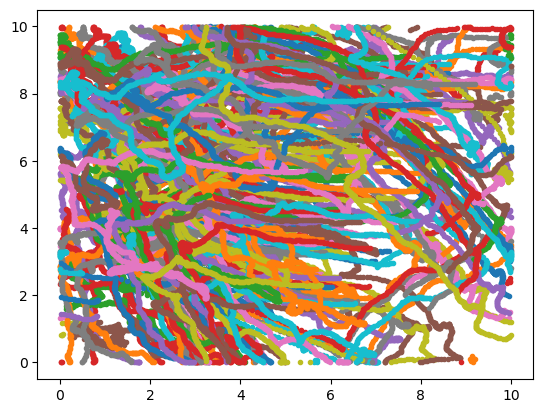

In [13]:
plt.plot(np.array(model.history)[:, :, 0], np.array(model.history)[:, :, 1],'.');

### Questions

+ Implement the Vicsek model of self-propelled particles. 

+ + Using for loops
+ + Using numpy vectorization

+ How do you expect the runtime of your implementation to scale with the number of particles? 

+ Examine the properties of your implementation

+ You had the option of vectorizing across particles. Why can't you vectorize across time steps?

+ In real-world systems, organisms have a finite field of view. For example, birds can only see a certain distance on either side of them. How would you modify your Vicsek model implementation to include this effect? How would you expect this to change the transition between order and disorder?

+ How is the Vicsek model related to the Ising model? What are the key differences, and how do these affect the different qualitative dynamical regimes of the two models?

### Further Reading

+ The Toner-Tu model

+ Starling papers